# base_model

> In this module we have the base model, learner and other things we need to train encoder
 





In [ ]:
#| default_exp base_model

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

In [ ]:
#| hide
device='cuda' if torch.cuda.is_available() else 'cpu'

Here we have the base functions and classes to train a basic BT-style model. Note that this (mostly) all comes directly from here: `https://github.com/KeremTurgutlu/self_supervised/blob/main/nbs/14%20-%20barlow_twins.ipynb` but we needed to modify some of the functions slightly for our purposes. 

In [ ]:
#| export
#Base functions / classes we need to train a BT / RBT model.

#TODO: We can make these more abstract so can incrementally modify to build `bt/rbt` and also `new idea.` But for 
#sake of readability, might be easier to just modify the defintions elsewhere. Come back to this later...
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):
        self.encoder = encoder
        self.projector = projector
        
    def forward(self,x): 
        
        return self.projector(self.encoder(x))

def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
        self.n_in=n_in
        
        self.index=-1 #Gets updated after each batch
        self.seed = np.random.randint(0,10000) #gets updated after each batch
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):
        
        indexmod=2
        if self.index%indexmod == 0: 
            self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1
            
    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
        elif self.n_in == 3:
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))

        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1
        self.update_seed()
        
    @torch.no_grad()
    def show(self, n=1): 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

BarlowTwins needs an `lf` method to work properly. Here we provide the `lf` of standard barlow twins. Later we can
patch in a new defintion of `lf` that involves random functions, inner maximization etc. The tools needed to do this are provised in `base_lf`

In [ ]:
#| export
def lf_bt(pred,I,lmb):
    bs,nf = pred.size(0)//2,pred.size(1)
    
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2
    loss = (cdiff*I + cdiff*(1-I)*lmb).sum() 
    return loss

In [ ]:
#| export
@patch
def lf(self:BarlowTwins, pred,*yb):
    return lf_bt(pred, self.I,self.lmb)

Here we show how to use the above functions in an end to end fashion. First we get some data and plonk it into a dls. Then create an encoder, an augmentation pipeline, a learner, then fit
the learner. This is the complete process of training BT. 

In [ ]:
#| hide
# #This should be equivalent to BarlowTwins. No extra functionality
# class RegBarlowTwins(BarlowTwins):
#     def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
#         super().__init__(aug_pipelines=aug_pipelines,lmb=lmb,print_augs=print_augs)

In [ ]:
#| hide
#Get some MNIST data and plonk it into a dls
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items = items[0:10]
split = RandomSplitter(valid_pct=0.0)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items))
dls = tds.dataloaders(bs=2,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)

#Full usage of above
ps=500
hs=500
n_in=1
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=(device=='cuda'))
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,print_augs=True)])
learn.fit(1)



Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


epoch,train_loss,valid_loss,time
0,2230.510498,None,00:01


For completeness, here is an example of augmentations on CIFAR10:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 's': (2, 4), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 's': (2, 4), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}
hi


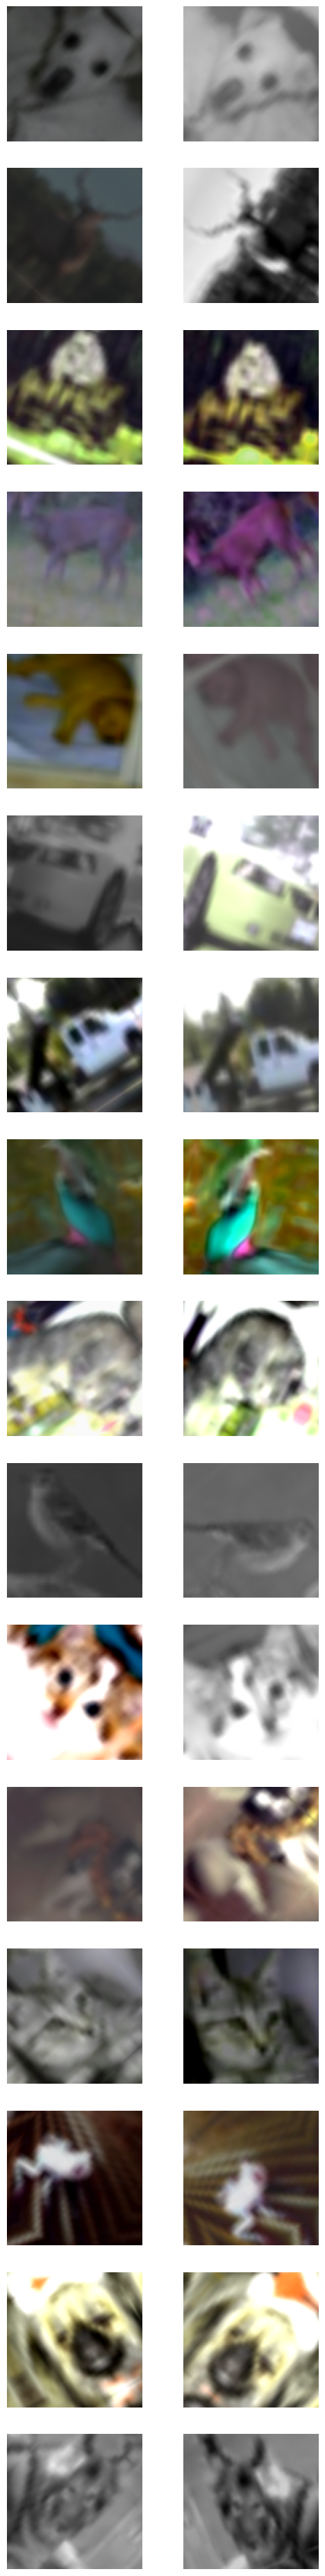

In [ ]:
#| hide

n_in=3
size=128
bs=16
path = untar_data(URLs.CIFAR)
items = get_image_files(path / "train")
items=items.shuffle()
items = items[0:100]
split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items, [[PILImage.create,Resize(size)], [parent_label, Categorize()]], splits=split(items)) #Or do we want this?
dls = tds.dataloaders(bs=bs,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)

fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
aug_pipelines = get_barlow_twins_aug_pipelines(size=size,bw=True, rotate=True, jitter=True, blur=True, resize_scale=(0.8, 1.0), resize_ratio=(0.5, 2.0), rotate_deg=60, jitter_s=0.7, blur_s=(2, 4), same_on_batch=False,bw_p=0.25, flip_p=0.5, rotate_p=1.0, jitter_p=1.0, blur_p=1.0, cuda=True, xtra_tfms=[])
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in, print_augs=True)])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=bs)

And training on CIFAR10

In [ ]:
#| hide
n_in=3
ps=1024 
hs=ps
fastai_encoder = create_fastai_encoder(xresnet34(),pretrained=False,n_in=n_in)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)
aug_pipelines = get_barlow_twins_aug_pipelines(size=size, rotate=True, jitter=True, bw=False, blur=True, resize_scale=(0.8, 1.0), resize_ratio=(0.5, 2.0), rotate_deg=60, jitter_s=0.7, blur_s=(2, 4), same_on_batch=False, flip_p=0.5, rotate_p=1.0, jitter_p=1.0, bw_p=1.0, blur_p=1.0, cuda=True, xtra_tfms=[])
learn = Learner(dls, model ,cbs=[BarlowTwins(aug_pipelines,n_in=n_in, print_augs=True)])
learn.fit(1)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGaussianBlur -- {'p': 1.0, 's': (2, 4), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGaussianBlur -- {'p': 1.0, 's': (2, 4), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}


epoch,train_loss,valid_loss,time
0,1189.437012,None,00:34


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()